# giant_midi_pianoのペアデータ作成  
* MIDIトークンと音楽属性値のペアデータ
* 拡散モデルの学習処理で、すでに256長でトークン化されたデータを用いる

In [ ]:
import torch
from miditoolkit import MidiFile
from miditok import MIDILike, REMI, Structured

import os
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from typing import List

from symbolic_music.datasets import create_midi_dataloader, __generate_input_ids, __create_embedding_model, __padding, LargeMidiDataset, __tokenize, __generate_data_list
from symbolic_music.utils import get_tokenizer
import random
from improved_diffusion.text_datasets import _collate_batch_helper
from improved_diffusion.utils import point_debug
from symbolic_music.advanced_padding import advanced_remi_bar_block
from symbolic_music.rounding import tokens_list_to_midi_list
from improved_diffusion import dist_util, logger



## valid_splitデータについて    
→ padded_tokens_list_train.npz

In [235]:
import numpy as np

MIDItoken_valid = np.load("../../improved-diffusion/diffusion_models_first/diff_midi_giant_midi_piano_REMI_bar_block_rand32_transformer_lr0.0001_0.0_2000_sqrt_Lsimple_h128_s2_d0.1_sd102_xstart_midi/padded_tokens_list_valid.npz")
MIDItoken_valid.files

['arr_0']

In [48]:
MIDItoken_valid['arr_0'].shape

(19955, 256)

In [49]:
MIDItoken_valid['arr_0']

array([[  1, 200,  69, ...,   0,   0,   0],
       [  1, 186,  69, ...,   0,   0,   0],
       [  1, 189,  62, ...,   0,   0,   0],
       ...,
       [  1, 188,  29, ...,   0,   0,   0],
       [  1, 189,  62, ...,   0,   0,   0],
       [  1, 186,  33, ...,   0,   0,   0]])

## train_splitデータについて   
→ padded_tokens_list_valid.npz

In [2]:
import numpy as np

MIDItoken_train = np.load("../../improved-diffusion/diffusion_models_first/diff_midi_giant_midi_piano_REMI_bar_block_rand32_transformer_lr0.0001_0.0_2000_sqrt_Lsimple_h128_s2_d0.1_sd102_xstart_midi/padded_tokens_list_train.npz")
MIDItoken_train.files

MIDItoken_train['arr_0'].shape

(364871, 256)

## MIDIトークン → MIDI

###   トークン→MIDIに戻す

In [5]:
def get_tokenizer0(miditok, padding_mode):
    cls = MIDILike
    if miditok == 'REMI':
        cls = REMI
    elif miditok == 'Structured':
        cls = Structured
    print(f'Use tokenizer {cls.__name__}')
    if padding_mode == 'bar_block':
        assert miditok == 'REMI'
        return cls(sos_eos_tokens=False, mask=False)
    return cls(sos_eos_tokens=True, mask=False)

def tokens_list_to_midi_list0(miditok,padding_mode,indices):
    # v -> k
    tokenizer = get_tokenizer0(miditok,padding_mode)
    return [
        tokenizer.tokens_to_midi([[x.item() for x in seq]], [(0, False)])
        for seq in indices
    ]
    
def save_results0(out_dir, top_p, midi_list):
    for i, midi in enumerate(midi_list):
        out_path2 = os.path.join(out_dir, f"{i}.mid")
        midi.dump(out_path2)

In [7]:
out_dir = '../../datasets/midi/giant_midi_piano/train_split' # MIDIデータを保存
save_results0(out_dir, 19955, tokens_list_to_midi_list0('REMI','bar_block',  MIDItoken_train['arr_0']))

Use tokenizer REMI


improved-diffusion/diffusion_models_first/diff_midi_giant_midi_piano_REMI_bar_block_rand32_transformer_lr0.0001_0.0_2000_sqrt_Lsimple_h128_s2_d0.1_sd102_xstart_midi/padded_tokens_list_train.npz

## 音楽属性値取り出し
* ./jSymbolic_feature_gpu.py → 一旦CSVファイルに保存
* GPUを用いないと時間がかかる...?

### validデータの音楽属性値

* './giant_midi_piano__valid_split_attribute.csv'

In [236]:
# npzファイル (256トークン)
MIDItoken = MIDItoken_valid['arr_0']


In [242]:
# csvファイル読み込み
df = pd.read_csv('./giant_midi_piano__valid_split_attribute.csv')
filename = df['0'].values
# データ名の処理
filename_new = []
j = 0
for j in range(12301):
    filename_new.append(filename[j][-11:-4])
    j = j + 1
    
print(filename_new)

['5_10055', '5_10056', '5_10051', '5_10052', '5_10053', '5_10050', '5_10054', '5_10057', '5_10060', '5_10061', '5_10058', '5_10059', '55_1006', '5_10063', '5_10062', '5_10064', '5_10067', '5_10065', '5_10068', '5_10066', '5_10069', '55_1007', '5_10070', '5_10071', '5_10072', '5_10073', '5_10074', '5_10077', '5_10075', '5_10076', '5_10079', '5_10078', '55_1008', '5_10080', '5_10081', '5_10083', '5_10082', '5_10084', '5_10085', '5_10086', '5_10087', '5_10090', '5_10089', '5_10092', '5_10091', '55_1009', '5_10093', '5_10088', '5_10094', '5_10095', '5_10097', '5_10096', '5_10098', '55_1010', '955_101', '5_10099', '5_10100', '5_10101', '5_10104', '5_10103', '5_10102', '5_10107', '5_10105', '5_10106', '5_10108', '5_10109', '55_1011', '5_10112', '5_10110', '5_10111', '5_10113', '5_10114', '5_10116', '5_10118', '55_1012', '5_10121', '5_10120', '5_10123', '5_10124', '5_10125', '5_10126', '5_10127', '5_10128', '5_10129', '55_1013', '5_10133', '5_10134', '5_10137', '5_10135', '5_10136', '55_1014'

### trainデータの音楽属性値

* '/giant_midi_piano__train_split_attribute.csv'

In [3]:
# MIDIトークン取り出し
MIDItoken_train = MIDItoken_train['arr_0']

* 音楽属性値の順番を確認 (index)

In [13]:
# csvファイル読み込み
df_train = pd.read_csv('../../improved-diffusion/emogen/jSymbolic_lib/giant_midi_piano__train_split_attribute.csv')
filename_train = df_train['0'].values
print(type(filename_train)) # <class 'numpy.ndarray'>
print(len(filename_train)) # 212967

filename_train_new = []
j = 0
for j in range(212967):
    filename_train_new.append(filename_train[j][-12:-4])
    j = j + 1 
print(filename_train_new[:100])

['_split/3', '_split/7', '_split/2', '_split/4', '_split/5', '_split/0', '_split/6', '_split/1', '_split/8', '_split/9', 'split/10', 'split/11', 'split/12', 'split/13', 'split/14', 'split/15', 'split/20', 'split/22', 'split/21', 'split/24', 'split/28', 'split/37', 'split/40', 'split/45', 'split/53', 'split/51', 'split/56', 'split/57', 'split/60', 'split/61', 'split/67', 'split/70', 'split/71', 'split/74', 'split/73', 'split/90', 'split/91', 'split/97', 'split/99', 'split/98', 'plit/102', 'plit/105', 'plit/106', 'plit/109', 'plit/110', 'plit/119', 'plit/121', 'plit/122', 'plit/125', 'plit/132', 'plit/133', 'plit/135', 'plit/134', 'plit/138', 'plit/139', 'plit/141', 'plit/140', 'plit/146', 'plit/149', 'plit/151', 'plit/152', 'plit/153', 'plit/154', 'plit/161', 'plit/160', 'plit/164', 'plit/163', 'plit/162', 'plit/170', 'plit/174', 'plit/171', 'plit/172', 'plit/176', 'plit/178', 'plit/179', 'plit/182', 'plit/180', 'plit/181', 'plit/184', 'plit/186', 'plit/188', 'plit/189', 'plit/187', 'pl

### (※ ファイルの中身整理)

* ファイル名の統一
* ファイルの順番を整理

In [7]:
import cupy as npg
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

import torch
print(torch.cuda.is_available())

True


* validデータの音楽属性値のファイル番号：MIDIトークンの方に合わせる

In [7]:
to_save_attribute_list_path = f'../../datasets/midi/giant_midi_piano/tokens_list_train.npz'
i = 0
filename_list = npg.zeros((0,1495),dtype=npg.float32)

for i in range(19955):
    name0 = '19955_'+ str(i)
        #if not (index == 'ValueError'):
    try:
        index = filename_new.index(name0[-7:])
        #print(index)
        attribute = df.values[index][1:].reshape(1,-1)
        filename_list = npg.append(filename_list, npg.asarray(attribute,npg.float32), axis=0)
        if i%100 == 0:
            print(index)
    except ValueError:
        pass

npg.savez(to_save_attribute_list_path, filename_list)
print(filename_list)

12265
6873
7585
8291
9600
10309
11592
12270
710
1370
6874
6948
7097
7289
7348
7422
7516
7588
7725
8018
8159
8233
8293
8341
8479
8542
8660
8874
9005
9152
9217
9270
9343
9401
9603
9756
9886
9943
10023
10080
10145
10238
10489
10729
10803
10962
11091
11160
11333
11437
11511
11594
11663
11751
11832
11893
11962
12062
12195
12272
56
140
232
305
437
527
648
709
769
1082
1230
1285
1373
1448
1523
1736
1928
1979
2119
2198
2263
2324
2406
2543
2683
2752
2933
3075
3143
3211
3440
3512
3569
3636
3792
3857
3919
4126
4291
4379
4457
4583
4710
4770
4848
4937
5071
5132
5201
5259
5327
5650
5999
6130
6231
6354
6518
6810
[[ 0.     0.     0.    ... 17.78  17.78  18.95 ]
 [ 0.     0.     0.    ... 15.84  15.84  16.23 ]
 [ 0.     0.     0.    ... 18.12  18.12  17.54 ]
 ...
 [ 0.     0.     0.    ...  7.826  7.826  5.6  ]
 [ 0.     0.     0.    ...  6.338  6.338  6.588]
 [ 0.     0.     0.    ...  7.683  7.683  7.826]]


* trainデータの音楽属性値：順番に並び直す

1. MIDIトークンの方(token_train)を並び替える　(validと逆)

In [11]:
MIDItoken_train[1].reshape(1,-1).shape

(1, 256)

In [14]:
# print(filename_list_train.shape)
to_save_train_token_list_path = f'../../datasets/midi/giant_midi_piano/train_tokens_attribute_sort.npz' # MIDIトークンを、音楽属性値を取り出した順に並び替えて保存
filename_train_new_midi = [] # 音楽属性値の順番
token_train = npg.zeros((0,256),dtype=npg.float32)
j = 0
for j in range(212967):
    filename_train_new_midi0 = filename_train_new[j].replace("/", " ").split()
    #print(filename_train_new_midi0[1]) #　音楽属性値の番号のみを取り出し(順番バラバラ)
    filename_train_new_midi.append(int(filename_train_new_midi0[1])) # 音楽属性値に対応した「MIDIトークン」抜き出し
    token_train = npg.append(token_train, npg.asarray( MIDItoken_train[int(filename_train_new_midi0[1])].reshape(1,-1),npg.float32), axis=0)
    j = j + 1
    if j%1000 == 0:
        print(j)
    
#print(filename_new_midi.sort())
npg.savez(to_save_train_token_list_path, token_train)
print(filename_train_new_midi) # 音楽属性値の順番すべて
print(token_train)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

2. 音楽属性値のみを取り出す：attribute_train

In [16]:
df_train.values[1][1:].reshape(1,-1) 

array([[0.0, 0.0, 0.0, ..., 12.21, 12.21, 11.18]], dtype=object)

In [34]:
to_save_train_attribute_path = f'../../datasets/midi/giant_midi_piano/train_attribute.npz'
j = 0
attribute_train = npg.zeros((0,1495),dtype=npg.float32)

attribute_train0 = df_train.loc[:,'1':'1495']
print(attribute_train0.values)

attribute_train = npg.append(attribute_train, npg.asarray( attribute_train0.values,npg.float32), axis=0)

npg.savez(to_save_train_attribute_path, attribute_train)
print(attribute_train)
print(attribute_train.shape)

[[0.0 0.0 0.0 ... 8.623 8.623 8.716]
 [0.0 0.0 0.0 ... 12.21 12.21 11.18]
 [0.0 0.0 0.0 ... 8.905 8.905 9.371]
 ...
 [0.0 0.0 0.0 ... 9.601 9.601 9.855]
 [0.0 0.0 0.0 ... 6.306 6.306 6.0]
 [0.0 0.0 0.0 ... 6.631 6.631 6.5]]
[[ 0.     0.     0.    ...  8.623  8.623  8.716]
 [ 0.     0.     0.    ... 12.21  12.21  11.18 ]
 [ 0.     0.     0.    ...  8.905  8.905  9.371]
 ...
 [ 0.     0.     0.    ...  9.601  9.601  9.855]
 [ 0.     0.     0.    ...  6.306  6.306  6.   ]
 [ 0.     0.     0.    ...  6.631  6.631  6.5  ]]
(212967, 1495)


# 分類器：回帰モデルの作成  
*「MIDI音楽」→「音楽属性値」  

## (1. validデータ関連の処理)

x：「MIDI音楽」... MIDItoken_valid['arr_0'] (19955, 256)  
y：「音楽属性値」... a['arr_0'] (12301,1495)

In [238]:
#print(filename_list)
#  a ... 音楽属性値  
a = np.load("../../datasets/midi/giant_midi_piano/tokens_list_train.npz")
print(a['arr_0'].shape)
#print(len(df.values))

(12301, 1495)


In [243]:
filename_new_midi = []
j = 0
for j in range(12301):
    filename_new_midi0 = filename_new[j].replace("_", " ").split()
    print(filename_new_midi0)
    print(filename_new_midi0[1])
    print(int(filename_new_midi0[1]))
    filename_new_midi.append(int(filename_new_midi0[1]))
    j = j + 1
    
print(filename_new_midi.sort())
print(filename_new_midi)

['5', '10055']
10055
10055
['5', '10056']
10056
10056
['5', '10051']
10051
10051
['5', '10052']
10052
10052
['5', '10053']
10053
10053
['5', '10050']
10050
10050
['5', '10054']
10054
10054
['5', '10057']
10057
10057
['5', '10060']
10060
10060
['5', '10061']
10061
10061
['5', '10058']
10058
10058
['5', '10059']
10059
10059
['55', '1006']
1006
1006
['5', '10063']
10063
10063
['5', '10062']
10062
10062
['5', '10064']
10064
10064
['5', '10067']
10067
10067
['5', '10065']
10065
10065
['5', '10068']
10068
10068
['5', '10066']
10066
10066
['5', '10069']
10069
10069
['55', '1007']
1007
1007
['5', '10070']
10070
10070
['5', '10071']
10071
10071
['5', '10072']
10072
10072
['5', '10073']
10073
10073
['5', '10074']
10074
10074
['5', '10077']
10077
10077
['5', '10075']
10075
10075
['5', '10076']
10076
10076
['5', '10079']
10079
10079
['5', '10078']
10078
10078
['55', '1008']
1008
1008
['5', '10080']
10080
10080
['5', '10081']
10081
10081
['5', '10083']
10083
10083
['5', '10082']
10082
10082
['5', '

In [ ]:
import torch

xMIDI = MIDItoken_valid['arr_0'][filename_new_midi]
type(torch.from_numpy(xMIDI))

In [ ]:
ymusic =np.nan_to_num(a['arr_0'])
print(ymusic)
print(type(ymusic))
print(torch.from_numpy(ymusic))

[[ 0.     0.     0.    ... 17.78  17.78  18.95 ]
 [ 0.     0.     0.    ... 15.84  15.84  16.23 ]
 [ 0.     0.     0.    ... 18.12  18.12  17.54 ]
 ...
 [ 0.     0.     0.    ...  7.826  7.826  5.6  ]
 [ 0.     0.     0.    ...  6.338  6.338  6.588]
 [ 0.     0.     0.    ...  7.683  7.683  7.826]]
<class 'numpy.ndarray'>
tensor([[ 0.0000,  0.0000,  0.0000,  ..., 17.7800, 17.7800, 18.9500],
        [ 0.0000,  0.0000,  0.0000,  ..., 15.8400, 15.8400, 16.2300],
        [ 0.0000,  0.0000,  0.0000,  ..., 18.1200, 18.1200, 17.5400],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  7.8260,  7.8260,  5.6000],
        [ 0.0000,  0.0000,  0.0000,  ...,  6.3380,  6.3380,  6.5880],
        [ 0.0000,  0.0000,  0.0000,  ...,  7.6830,  7.6830,  7.8260]])


## 2. trainデータ関連の処理  
→ (validと逆)    
* MIDIトークン...音楽属性値に合わせて並び替えたnpzファイル読み込み：token_train  
'./train_tokens_attribute_sort.npz'  
  
* 音楽属性値...ファイル名を取り除いたnpzファイル読み込み：attribute_train  
'./train_attribute.npz'




In [ ]:
import numpy as np
token_train0 = np.load('../../datasets/midi/giant_midi_piano/train_tokens_attribute_sort.npz')
attribute_train0 = np.load('../../datasets/midi/giant_midi_piano/train_attribute.npz')

print(attribute_train0['arr_0'].shape)
print(token_train0['arr_0'].shape)
attribute_train = attribute_train0['arr_0']
token_train = token_train0['arr_0']

(212967, 1495)
(212967, 256)


* 属性値1495 → 100

In [5]:
# #音楽属性値の0,1の値を決める関数
def binarize_command(command, thresholds):
        discrete_feature = []
        for k in range(command.shape[0]):
            thres = thresholds[k]
            discrete_feature.append(np.searchsorted(thres, command[k]))
        return discrete_feature

In [6]:
thresholds = np.load("../../improved-diffusion/emogen/data/threshold.npy", allow_pickle=True) #閾値
feature_index = np.load("../../improved-diffusion/emogen/data/feature_index.npy", allow_pickle=True) #特徴量100

#print(attribute100.tolist())
attribute100_train = []
for k ,t_k in enumerate(attribute_train):
    # binary_command = binarize_command(ymusic[k][feature_index], thresholds)
    binary_command = attribute_train[k][feature_index]
    attribute100_train.append(binary_command)
attribute100_train = np.array(attribute100_train)
print(attribute100_train.shape)
print(type(attribute100_train))

(212967, 100)
<class 'numpy.ndarray'>


* validデータ   1496→100

In [247]:
a_100 = []
for k_v ,t_k_v in enumerate(ymusic):
    # binary_command = binarize_command(ymusic[k][feature_index], thresholds)
    binary_command_valid = ymusic[k_v][feature_index]
    a_100.append(binary_command_valid)
a_100 = np.array(a_100)
print(a_100.shape)

(12301, 100)


### (PCA 次元削除 100 → 30)

* token_train：(212967, 256)
* attribute100_train：(212967, 100)

音楽属性値の正規化(tanh)を先に行う

In [10]:
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [7]:
attribute100_train = np.nan_to_num(attribute100_train)
token_train = np.nan_to_num(token_train)

# PCA（主成分分析）を使って次元を２次元に削減
pca = PCA(n_components=30)
vectors = pca.fit_transform(attribute100_train)
vectors.shape

(212967, 30)

In [15]:
# 寄与率を算出
contribution_ratios = pca.explained_variance_ratio_
print(contribution_ratios)

# 累積寄与率を算出（.cusum()で累積和を計算 .sum()では総和しか得られない）
cumulative_contribution_ratios = contribution_ratios.cumsum()
cumulative_contribution_ratios

[3.03626060e-01 2.78433263e-01 8.44649374e-02 6.41971454e-02
 5.77553324e-02 4.01567705e-02 3.80358063e-02 3.04297563e-02
 2.64969599e-02 2.32927278e-02 9.55170020e-03 7.47387111e-03
 6.35353569e-03 5.68782119e-03 4.87609720e-03 3.96256475e-03
 3.30497045e-03 2.71977903e-03 2.56768335e-03 2.28016311e-03
 1.24037499e-03 1.16354460e-03 6.44881919e-04 2.75288679e-04
 2.44960043e-04 1.19717544e-04 7.55220972e-05 5.89523879e-05
 5.16680957e-05 4.51757078e-05]


array([0.30362606, 0.5820593 , 0.6665243 , 0.7307214 , 0.78847677,
       0.82863355, 0.86666936, 0.89709914, 0.9235961 , 0.9468888 ,
       0.9564405 , 0.9639144 , 0.97026795, 0.9759558 , 0.98083186,
       0.98479444, 0.9880994 , 0.99081916, 0.99338686, 0.99566704,
       0.9969074 , 0.99807096, 0.9987158 , 0.99899113, 0.9992361 ,
       0.99935585, 0.9994314 , 0.9994903 , 0.999542  , 0.9995872 ],
      dtype=float32)

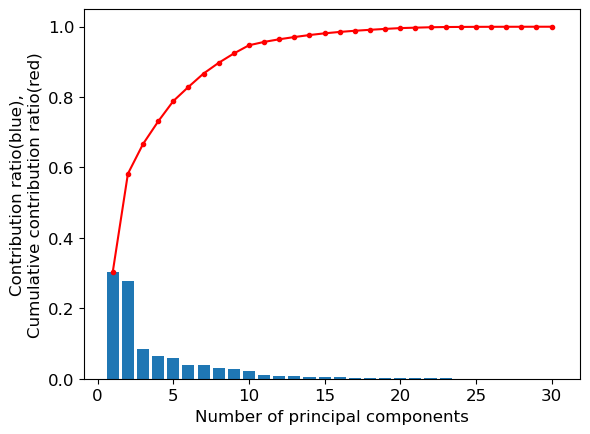

In [18]:
cont_cumcont_ratios = np.concatenate([contribution_ratios, cumulative_contribution_ratios], axis=0).T
cont_cumcont_ratios_name = ['contribution_ratio', 'cumulative_contribution_ratio']  # 行の名前を変更
# 寄与率を棒グラフで、累積寄与率を線で入れたプロット図を重ねて描画
x_axis = range(1, contribution_ratios.shape[0] + 1)  # 1 から成分数までの整数が x 軸の値
plt.rcParams['font.size'] = 12
plt.bar(x_axis, contribution_ratios, align='center')  # 寄与率の棒グラフ
plt.plot(x_axis, cumulative_contribution_ratios, 'r.-')  # 累積寄与率の線を入れたプロット図
plt.xlabel('Number of principal components')  # 横軸の名前
plt.ylabel('Contribution ratio(blue),\nCumulative contribution ratio(red)')  # 縦軸の名前。\n で改行しています
plt.show()


validデータの場合
* xMIDI : (12301,256)
* a_100 :(12301,100)

In [257]:
a_100 = np.nan_to_num(a_100)
xMIDI = np.nan_to_num(xMIDI)

# PCA（主成分分析）を使って次元を２次元に削減
pca = PCA(n_components=32)
vectors_valid = pca.fit_transform(a_100)
vectors_valid.shape

(12301, 32)

## 回帰モデル nn.Linear

In [2]:
import os
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"run with {device}")

run with cuda


In [3]:
# 主要モジュール
import torch
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt

# 学習用のサンプルデータ
from sklearn import datasets

# データを整理する
from torch.utils.data import DataLoader

# 全結合層と活性化関数
from torch import nn
from torch.nn import functional as F

# 損失関数と最適化関数
from torch import optim

## (1. valid回帰モデル)
* xMIDI
* ymusic

In [ ]:
xMIDI = np.nan_to_num(xMIDI)
#ymusic = np.nan_to_num(ymusic)
vectors_valid = np.nan_to_num(vectors_valid)

In [ ]:
print(type(xMIDI))
#print(type(ymusic))

<class 'numpy.ndarray'>


In [ ]:
# 3.ndarrayをTensorに変換
xMIDI = torch.from_numpy(xMIDI).to(device)
# ymusic = torch.from_numpy(ymusic).to(device)
vectors_valid = torch.from_numpy(vectors_valid).to(device)

# 4.TensorからDatasetを作成
dataset = torch.utils.data.TensorDataset(xMIDI.to(torch.float32), vectors_valid.to(torch.float32))

# 5.学習用データとテスト用データに分ける
r = 0.8
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [r,1-r])



In [118]:
# 6.DataLoaderに変換
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

## 2. train回帰モデル

In [8]:
# attribute_train = np.nan_to_num(attribute_train)
attribute100_train = np.nan_to_num(attribute100_train)
token_train = np.nan_to_num(token_train)
# vectors = np.nan_to_num(vectors) # vectors：PCA30

print(type(attribute100_train))
print(type(token_train))
#print(type(vectors))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
print(attribute100_train.shape)
print(token_train.shape)

(212967, 100)
(212967, 256)


In [9]:
import torch
import numpy as np
thresholds = np.load("../../improved-diffusion/emogen/data/threshold.npy", allow_pickle=True)
print(torch.from_numpy(thresholds.T).shape)

thresholds2 = torch.from_numpy(thresholds.T).unsqueeze(2)
print(thresholds2.shape) 

thresholds3 = thresholds2.repeat(16,1, 32)
print(thresholds3.shape) 

torch.Size([1, 100])
torch.Size([1, 100, 1])
torch.Size([16, 100, 32])


* (音楽属性値100：**Torch.ge(gt)** で閾値を使用 → attribute100_train**2**)　


In [ ]:
attribute100_train2 = torch.ge(torch.from_numpy(attribute100_train) , torch.from_numpy(thresholds.T))

print(attribute100_train2)
print(attribute100_train2.shape)

tensor([[ True, False,  True,  ..., False, False, False],
        [False,  True,  True,  ...,  True,  True,  True],
        [False, False,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ...,  True, False, False],
        [False,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])
torch.Size([212967, 100])


In [10]:
print(attribute100_train)
print(token_train)

[[ 0.1493   0.       0.1194  ...  0.       8.623    8.716  ]
 [ 0.06849  0.05479  0.137   ...  0.04167 12.21    11.18   ]
 [ 0.05714  0.       0.1286  ...  0.       8.905    9.371  ]
 ...
 [ 0.02899  0.       0.02899 ...  0.05556  9.601    9.855  ]
 [ 0.       0.02703  0.1486  ...  0.01361  6.306    6.     ]
 [ 0.1528   0.06944  0.1389  ...  0.       6.631    6.5    ]]
[[  1. 189.  35. ...   0.   0.   0.]
 [  1. 188.  38. ...   0.   0.   0.]
 [  1. 187.  40. ...   0.   0.   0.]
 ...
 [  1. 189.  33. ...   0.   0.   0.]
 [  1. 190.  40. ...   0.   0.   0.]
 [  1. 191.  21. ...  43. 113. 135.]]


In [10]:
# 3.ndarrayをTensorに変換 (2度実行したらエラー出る)
# attribute_train = torch.from_numpy(attribute_train).to(device)
attribute100_train = torch.from_numpy(attribute100_train).to(device)
# vectors = torch.from_numpy(vectors).to(device)
token_train = torch.from_numpy(token_train).to(device)

# 4.TensorからDatasetを作成
#dataset_train = torch.utils.data.TensorDataset(token_train.to(torch.float32), attribute_train.to(torch.float32))
dataset_train = torch.utils.data.TensorDataset(token_train.to(torch.float32), attribute100_train.to(torch.float32))
dataset_train2 = torch.utils.data.TensorDataset(token_train.to(torch.float32), attribute100_train2.to(torch.float32)) #10/15
# dataset_train = torch.utils.data.TensorDataset(token_train.to(torch.float32), vectors.to(torch.float32)) # PCA30

# 5.学習用データとテスト用データに分ける
r = 0.8
train_dataset, test_dataset = torch.utils.data.random_split(dataset_train, [r,1-r])
train_dataset2, test_dataset2 = torch.utils.data.random_split(dataset_train2, [r,1-r]) #10/15

In [11]:
# 6.DataLoaderに変換
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

#
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=len(test_dataset), shuffle=False)

## モデルの学習

### 学習

* (PCAの場合)

In [15]:
# PCAの場合
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # 全結合層を3つ
        self.fc1 = nn.Linear(256, 256)#
        self.fc2 = nn.Linear(256, 30)#
        # self.fc3 = nn.Linear(100, 50)
        # self.fc4 = nn.Linear(50, 30)
        # self.fc5 = nn.Linear(30, 30)
        
        # 損失関数と最適化関数
        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(),0.0001)
        self.dropout = nn.Dropout(p=0.2)
        #self.pca = PCA(n_components=30, svd_solver="randomized", power_iteration_normalizer="QR")
        self.bn1 = nn.BatchNorm1d(256, track_running_stats=True)
        self.bn2 = nn.BatchNorm1d(30, track_running_stats=True) #100
        # self.bn3 = nn.BatchNorm1d(50, track_running_stats=True)
        # self.bn4 = nn.BatchNorm1d(30, track_running_stats=True)
        # self.bn5 = nn.BatchNorm1d(30, track_running_stats=True)
        
        

    def forward(self, x):  # batch_size = 256 , nn.MSELoss(), optim.Adam(self.parameters(),0.0001)
        x = self.fc1(x) #   = nn.Linear(256, 256)
        x = self.bn1(x) #   = nn.BatchNorm1d(256, track_running_stats=True)
        #x = self.dropout(x)
        x = F.leaky_relu(x) 
        x = self.fc2(x) #   = nn.Linear(256, 100)
        x = self.bn2(x) #   = nn.BatchNorm1d(30, track_running_stats=True) 
        x = F.leaky_relu(x)
        x = self.fc3(x) #   = nn.Linear(100, 50)
        x = self.bn3(x) #   = nn.BatchNorm1d(50, track_running_stats=True)
        x = F.leaky_relu(x)
        x = self.dropout(x)  #  = nn.Dropout(p=0.2)
        x = self.fc4(x) #   = nn.Linear(50, 30)
        x = self.bn4(x) #   = nn.BatchNorm1d(30, track_running_stats=True)
        x = F.leaky_relu(x)
        # x = self.dropout(x)
        x = self.fc5(x) # = nn.Linear(30, 30)
        x = self.bn5(x) # = nn.BatchNorm1d(30, track_running_stats=True)
        return x

* 256 → 100 の場合

In [5]:
# 256 → 100 の場合
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # 全結合層を3つ
        self.fc1 = nn.Linear(256, 256)#
        self.fc2 = nn.Linear(256, 100)#
        # self.fc3 = nn.Linear(100, 50)
        # self.fc4 = nn.Linear(50, 30)
        # self.fc5 = nn.Linear(30, 30)
        
        # 損失関数と最適化関数
        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(),0.01)
        self.dropout = nn.Dropout(p=0.2)
        #self.pca = PCA(n_components=30, svd_solver="randomized", power_iteration_normalizer="QR")
        self.bn1 = nn.BatchNorm1d(256, track_running_stats=True)
        self.bn2 = nn.BatchNorm1d(100, track_running_stats=True) #100
        # self.bn3 = nn.BatchNorm1d(50, track_running_stats=True)
        # self.bn4 = nn.BatchNorm1d(30, track_running_stats=True)
        # self.bn5 = nn.BatchNorm1d(30, track_running_stats=True)
        
        

    def forward(self, x):  # batch_size = 256 , nn.MSELoss(), optim.Adam(self.parameters(),0.0001)
        x = self.fc1(x) #   = nn.Linear(256, 256)
        x = self.bn1(x) #   = nn.BatchNorm1d(256, track_running_stats=True)
        #x = self.dropout(x)
        x = F.leaky_relu(x)
        #x = F.relu(x) #
        #x = self.dropout(x)
       # x = self.dropout(x)
        x = self.fc2(x) #
        #x = self.bn2(x)
        #x = F.relu(x)
        x = F.leaky_relu(x)
        
        # x = torch.ge(x,torch.from_numpy(thresholds.T))
        #x = F.relu(x)
        return x #torch.gt(x,torch.from_numpy(thresholds.T))

* 学習　(関数定義)

In [14]:
def train(model, data_loader):
    # 今は学習時であることを明示するコード
    model.train()

    # 正しい予測数、全体のデータ数を数えるカウンターの0初期化
    total_correct = 0
    total_data_len = 0

    loss_mean = 0

    # ミニバッチごとにループさせる,train_loaderの中身を出し切ったら1エポックとなる
    for j, (x, t) in enumerate(data_loader):
        y = model(x)  # 順伝播
        model.optimizer.zero_grad()  # 勾配を初期化（前回のループ時の勾配を削除）
        loss = model.criterion(y, t)  # 損失を計算
        loss.backward()  # 逆伝播で勾配を計算
        model.optimizer.step()  # 最適化

        loss_mean += loss.item()

        # ミニバッチごとの正答率と損失を求める
        _, index_y = torch.max(y, axis=1)  # 最も確率が高いと予測したindex
        _, index_t = torch.max(t, axis=1)  # 正解のindex
        for i in range(len(t)):  # データ一つずつループ,ミニバッチの中身出しきるまで
            total_data_len += 1  # 全データ数を集計
            if index_y[i] == index_t[i]:
                total_correct += 1 # 正解のデータ数を集計

    loss_mean = loss_mean / (j+1)

    return total_correct, total_data_len, loss_mean

def test(model, data_loader):
    # モデルを評価モードにする
    model.eval()

    # 正しい予測数、全体のデータ数を数えるカウンターの0初期化
    total_data_len = 0
    total_correct = 0

    loss_mean = 0

    for j, (x, t) in enumerate(data_loader):
        y = model(x)  # 順伝播（=予測）
        loss = model.criterion(y, t)  # 損失を計算
        loss_mean += loss.item()

        # ミニバッチごとの正答率と損失を求める
        _, index_y = torch.max(y, axis=1)  # 最も確率が高いと予測したindex
        _, index_t = torch.max(t, axis=1)  # 正解のindex
        for i in range(len(t)):  # データ一つずつループ,ミニバッチの中身出しきるまで
            total_data_len += 1  # 全データ数を集計
            if index_y[i] == index_t[i]:
                total_correct += 1 # 正解のデータ数を集計

    loss_mean = loss_mean / (j+1)

    return total_correct, total_data_len, loss_mean

* 学習

In [16]:
# アーキテクチャのインスタンス作成
model = Net().to(device)

#model = torch.jit.load('../../improved-diffusion/emogen/midi_musicat_LinearPCA.pth', map_location="cuda")
epochs = 10
record_train_loss = []
record_test_loss = []
for epoch in range(epochs):
    train_correct_len, train_data_len, train_loss = train(model, train_loader) # 10/15：train_loader →
    test_correct_len, test_data_len, test_loss = test(model, test_loader) # 10/15：test_loader →

    train_acc = train_correct_len/train_data_len*100
    test_acc = test_correct_len/test_data_len*100

    record_train_loss.append(train_loss)
    record_test_loss.append(test_loss)

    if epoch%1 == 0:
        print(f"epoch={epoch}, train:{train_correct_len}/{train_data_len}({train_acc:.2f}%), {train_loss:.5f}, test:{test_correct_len}/{test_data_len}({test_acc:.2f}%), {test_loss:.5f}")
    #if epoch%100 == 0:
        #model_scripted_train = torch.jit.script(model)
        #model_scripted_train.save('../../improved-diffusion/emogen/midi_musicat_LinearPCA.pth') #256→PCA

epoch=0, train:82646/170374(48.51%), 10.26919, test:22293/42593(52.34%), 6.29638
epoch=1, train:91663/170374(53.80%), 5.23444, test:23052/42593(54.12%), 5.02360
epoch=2, train:93453/170374(54.85%), 4.92510, test:23376/42593(54.88%), 4.85354
epoch=3, train:94081/170374(55.22%), 4.72484, test:23586/42593(55.38%), 4.51988
epoch=4, train:94715/170374(55.59%), 4.61138, test:23717/42593(55.68%), 4.53709
epoch=5, train:94633/170374(55.54%), 4.53231, test:23501/42593(55.18%), 4.50884
epoch=6, train:95233/170374(55.90%), 4.45245, test:23633/42593(55.49%), 4.45670
epoch=7, train:95494/170374(56.05%), 4.40317, test:23685/42593(55.61%), 4.47307
epoch=8, train:95694/170374(56.17%), 4.34670, test:23461/42593(55.08%), 4.40044
epoch=9, train:95996/170374(56.34%), 4.30065, test:23910/42593(56.14%), 4.34839


* モデル保存 (名前を変える)

In [ ]:
# Torch Script形式で保存
model_scripted = torch.jit.script(model)
#model_scripted.save('.pth')
torch.save(model_scripted.state_dict(),'.pth') #256→PCA

### モデル読み込み

In [1]:
import os
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"run with {device}")

run with cuda


モデルのモジュール (Class Net()) をロードする必要がある場合 
* モジュールをGPU仕様にする (Net2)

In [10]:
# 256 → 100 の場合
class Net2(nn.Module):
    def __init__(self):
        super().__init__()

        # 全結合層を3つ
        self.fc1 = nn.Linear(256, 256).cuda()#
        self.fc2 = nn.Linear(256, 100).cuda()#
        # self.fc3 = nn.Linear(100, 50)
        # self.fc4 = nn.Linear(50, 30)
        # self.fc5 = nn.Linear(30, 30)
        
        # 損失関数と最適化関数
        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.MSELoss().cuda()
        self.optimizer = optim.Adam(self.parameters(),0.01) #.cuda()
        self.dropout = nn.Dropout(p=0.2).cuda()
        #self.pca = PCA(n_components=30, svd_solver="randomized", power_iteration_normalizer="QR")
        self.bn1 = nn.BatchNorm1d(256, track_running_stats=True).cuda()
        self.bn2 = nn.BatchNorm1d(100, track_running_stats=True).cuda() #100
        # self.bn3 = nn.BatchNorm1d(50, track_running_stats=True)
        # self.bn4 = nn.BatchNorm1d(30, track_running_stats=True)
        # self.bn5 = nn.BatchNorm1d(30, track_running_stats=True)
        
        

    def forward(self, x):  # batch_size = 256 , nn.MSELoss(), optim.Adam(self.parameters(),0.0001)
        x = self.fc1(x) #   = nn.Linear(256, 256)
        x = self.bn1(x) #   = nn.BatchNorm1d(256, track_running_stats=True)
        #x = self.dropout(x)
        x = F.leaky_relu(x)
        #x = F.relu(x) #
        #x = self.dropout(x)
       # x = self.dropout(x)
        x = self.fc2(x) #
        #x = self.bn2(x)
        #x = F.relu(x)
        x = F.leaky_relu(x)
        
        # x = torch.ge(x,torch.from_numpy(thresholds.T))
        #x = F.relu(x)
        return x #torch.gt(x,torch.from_numpy(thresholds.T))

In [11]:
# Torch Script形式で読み込み
# model= torch.jit.load('../../improved-diffusion/emogen/traindatamidi_musicat_Linear.pth', map_location="cuda")
model= torch.load('.pth', map_location="cuda")

newmodel = Net2()
newmodel.load_state_dict(torch.load('7.pth', map_location="cuda"))



<All keys matched successfully>

In [18]:
print(model)

OrderedDict([('fc1.weight', tensor([[-0.0238, -2.2600,  1.8887,  ..., -2.8937, -2.5580, -2.0688],
        [ 0.0476, -3.3550,  1.2848,  ..., -4.4102, -3.2430, -2.1035],
        [ 0.0600,  2.9192,  1.2352,  ...,  0.0857, -0.0391, -0.0968],
        ...,
        [ 0.0132, -1.8819,  3.3219,  ...,  0.2867,  0.2055,  0.1756],
        [ 0.0397,  3.8517,  1.2287,  ..., -2.7208, -2.5038, -2.0331],
        [-0.0272, -2.2322,  2.3629,  ...,  0.2532,  0.0307, -0.0622]],
       device='cuda:0')), ('fc1.bias', tensor([-0.0283, -0.0556,  0.0377, -0.0410,  0.0289,  0.0238,  0.0119,  0.0011,
        -0.0103, -0.0249,  0.0332,  0.0346, -0.0192, -0.0304,  0.0478, -0.0377,
         0.0177,  0.0102,  0.0083, -0.0406, -0.0091, -0.0393, -0.0405,  0.0161,
         0.0562, -0.0159,  0.0554,  0.0359, -0.0420,  0.0545,  0.0181, -0.0571,
        -0.0511,  0.0231, -0.0211,  0.0570, -0.0497, -0.0395,  0.0604,  0.0108,
        -0.0557, -0.0083, -0.0048,  0.0433, -0.0452,  0.0486,  0.0055,  0.0465,
        -0.0357,  0

In [12]:
print(newmodel)

Net2(
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=100, bias=True)
  (criterion): MSELoss()
  (dropout): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


* cpuでロード

In [4]:
import torch
model_cpu = torch.jit.load('../../improved-diffusion/emogen/midi_musicat_Linear.pth', map_location="cpu")
print(model_cpu)

RecursiveScriptModule(
  original_name=Net
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
  (criterion): RecursiveScriptModule(original_name=CrossEntropyLoss)
)


## モデルの評価

In [ ]:
MIDI_valid = MIDItoken_valid['arr_0']
pred = newmodel(torch.from_numpy(token_train).to(torch.float32).to(device))

In [14]:
print(pred[0])

tensor([-7.8315e-03, -1.0677e-02, -1.2662e-02, -1.2192e-02, -3.7439e-03,
        -7.3292e-03,  2.1375e+01,  4.1809e+01,  2.8158e-01,  5.8880e-01,
         2.3019e-01,  6.2373e+01,  5.4075e+00,  6.1516e+01,  1.0092e+01,
        -2.0957e-01, -2.6900e-03, -1.1568e-02, -6.4763e-03, -2.2900e-02,
        -1.0524e-02, -5.6887e-03, -2.3533e-03, -3.9348e-03,  1.6965e-01,
         4.1044e-01, -1.0038e-02, -1.1971e-02,  3.1680e+00,  2.8252e+00,
        -5.4689e-03, -1.3533e-02, -1.8857e-03, -1.4697e-02, -2.5904e-03,
        -1.0135e-03, -6.1070e-03, -6.1521e-03, -3.4558e-03, -8.2561e-03,
        -3.3819e-03, -7.7216e-03, -9.3576e-03, -2.8121e-02, -6.5662e-04,
        -3.3096e-03,  2.0308e-01, -7.1375e-03, -1.0417e-02,  5.8965e-02,
        -5.2057e-03,  4.4066e+00,  2.1801e-01,  3.9210e-01,  2.7928e-01,
         2.8545e-01, -2.6513e-02,  1.1812e+00,  6.6166e+01,  6.9526e+00,
         3.3837e+00, -2.7801e-02,  2.2830e-01, -1.2397e-02, -1.6798e-02,
        -1.8936e-03, -1.5501e-03, -1.3796e-02, -1.4

### (1. validデータでの評価)

* コサイン類似度 (validデータで評価)

In [ ]:
# コサイン類似度
import numpy as np
import itertools

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

cos_sim_y_valid = 0.0
for i in range(12301):
   cos_sim_y_valid = cos_sim_y_valid + cos_sim(pred[i].cpu().detach().numpy(), a_100[i]) # 256→30
print(cos_sim_y_valid / 12301)

* ピアソン相関係数　(validデータで評価)

In [31]:
corrcoef_y = 0.0
#np.corrcoef(yy, y_test.numpy())[0,1]
for i in range(12301):
    corrcoef_y = corrcoef_y + np.corrcoef(pred_valid[i].cpu().detach().numpy(), a_100[i])[0,1] # -1 ~ 1cpr
print(corrcoef_y / 12301) # 12301

0.7983462234867009


### 2. trainデータでの評価

* コサイン類似度 (trainデータで評価)

In [22]:
# コサイン類似度
import numpy as np
import itertools

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

cos_sim_y = 0.0
for i in range(212967):
    # cos_sim_y = cos_sim_y + cos_sim(pred[i].cpu().detach().numpy(), ymusic[i].cpu().detach().numpy()) 
    cos_sim_y = cos_sim_y + cos_sim(pred[i].detach().cpu().numpy(), attribute100_train[i]) # 256→100
    # cos_sim_y = cos_sim_y + cos_sim(pred[i].cpu().detach().numpy(), vectors[i].cpu().detach().numpy()) # 256→30
print(cos_sim_y / 212967)

0.9897604146531885


* ピアソン相関係数　(trainデータで評価)

In [23]:
corrcoef_y = 0.0
#np.corrcoef(yy, y_test.numpy())[0,1]

for i in range(212967):
    corrcoef_y = corrcoef_y + np.corrcoef(pred[i].cpu().detach().numpy(), attribute100_train[i])[0,1] # -1 ~ 1cpr 256→100
    # corrcoef_y = corrcoef_y + np.corrcoef(pred[i].cpu().detach().numpy(), vectors[i].cpu().detach().numpy())[0,1] # -1 ~ 1cpr  256→30
print(corrcoef_y / 212967) # 12301

0.9888605772057638
